In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from numpy.random import uniform, normal
from jax import grad, vmap, jit, random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

YOU WU

# Error cuadrático no es todo lo que hay

El error cuadrático es una de las funciones de pérdida habituales que se optimiza cuando se aprenden modelos basados en funciones, pero no siempre tiene buenos resultados dependiendo de las características de los datos. Uno de sus principales problemas son los valores atípicos, ejemplos que tienen valores de salida fuera del rango normal.

La función de pérdida log cosh definida como:
$$$$
$$
l(y_n,f(x_n)) = log cosh(y_n-f(x_n))=log(\frac{e^{(y_n-f(x_n))}+e^{-(y_n-f(x_n))}}{2})
$$

El objetivo es optimizar una regresión de una variable definida como:
$$
f(x) = w_0 + w_1x
$$


## Apartado a

En esta sección vamos a representar la función de pérdida log cosh y el error cuadrático en el rango [−3, 3].
Error cuadrático se define como:
$$
MSE(y_n,f(x_n)) = \frac{1}{2}(y_n-f(x_n))^2
$$

En e siguiente código definimos las funciones de perdidas y la función de regressión.

In [2]:
@jax.jit
def reg(w,X):
  return jnp.sum(w*jnp.array([1,X]))

@jax.jit
def logCosh(w,X,y):
  exp = y-reg(w,X)
  elem1 = jnp.exp(exp);
  elem2 = jnp.exp(-exp);
  return jnp.log((jnp.exp(exp)+jnp.exp(-exp))/2)


@jax.jit
def lossMSE(w,X,y):
  return (y - reg(w,X))**2/2


A continuación podréis observar la repetación de la función log cosh y la función MSE mediante dos plots.

In [3]:
fig = plt.figure(figsize=(1,10))
key = jax.random.PRNGKey(0)
x1 = jnp.linspace(-3,3,500)
data = vmap(reg,in_axes=(None,0))(jnp.array([1,5]), x1)
y1 = data
import plotly.graph_objects as go
fig = go.Figure()
t = jnp.linspace(-3,3,500)
fig.add_trace(go.Scatter(x=t,y=logCosh(jnp.array([1,5]),0, y1), name="lossLogCosh"))
fig.update_layout(
    width=500,
    height=500)
fig.show()
fig = go.Figure()
fig.add_trace(go.Scatter(x=t,y=lossMSE(jnp.array([1,5]),0, y1),name="lossMSE"))
fig.update_layout(
    width=500,
    height=500)
fig.show()

<Figure size 72x720 with 0 Axes>

Como se puede observar a partir de los plots anteriores, los valores de salida la función Log cosh es más tolerante a los valores atípicos, para errores altos se comporta aproximadamente como: $$ (y_n-f(x_n))-log{2}$$. 

## Apartado b

En este apartado hemos definido el problema de regresión mediante el valor 1 y 0.7 para $w_0$ y $w_1$ respectivamente. utilizando uniform generamos dos conjuntos de datos de 100 ejemplos usando la distribución normal en el rango [−5, 5]. Dónde la salida para cada ejemplo usando la función:
$$
f(x) = w_0 + w_1x + \epsilon
$$

donde ϵ ∼ N(0, 2). Para el primer conjunto de datos vamos a generar ejemplos atípicos
añadiendo al 10% de los ejemplos un ruido normal adicional ϵ' ~ N(10, 2).

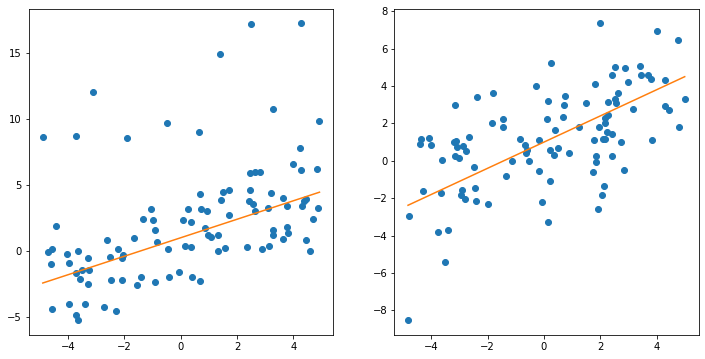

In [4]:
sigma = 2.
key = jax.random.PRNGKey(0)
randomKeys = jax.random.split(key, 3)
normal1 = jax.random.normal(randomKeys[0],shape=(100,))
normal2 = jax.random.normal(randomKeys[1], shape=(100,))
x2 = np.sort(uniform(-5,5,100))
x3 = np.sort(uniform(-5,5,100))
data2 = vmap(reg,in_axes=(None,0))(jnp.array([1,0.7]),x2) + (jax.random.normal(randomKeys[0],shape=(100,))*2) 
y3 = vmap(reg,in_axes=(None,0))(jnp.array([1,0.7]),x3) + (jax.random.normal(randomKeys[1],shape=(100,))*2)

noise = 10 + 2*jax.random.normal(randomKeys[2], shape=(10,)) #ruido addicional N(10,2)
y2 = np.zeros((100,))
for i in range(100):
  if i%10 == 0:
    y2[i,]=data2[i,]+noise[int(i/10),]
  else:
    y2[i,]=data2[i,]

fig, ax = plt.subplots(1,2,figsize=(12,6));
sample1 = pd.DataFrame({'input':x2,'target':y2})
ax[0].plot(sample1.input, sample1.target, 'o')
ax[0].plot(x2,vmap(reg,in_axes=(None,0))(jnp.array([1,0.7]),x2));
sample2 = pd.DataFrame({'input':x3,'target':y3})
ax[1].plot(sample2.input, sample2.target, 'o')
ax[1].plot(x3,vmap(reg,in_axes=(None,0))(jnp.array([1,0.7]),x3));

##Apartado C

Para poder encontrar el mínimo de las funciones de pérdida, buscamos la derivada parcial para cada uno de ellos.

Por primera parte, haremos la derivada de la función log cosh:

$$
𝑙(𝑦𝑛,𝑓(𝑥𝑛))=log cosh(y_n-f(x_n))=log(\frac{e^{(y_n-f(x_n))}+e^{-(y_n-f(x_n))}}{2}) = log({e^{(y_n-f(x_n))}+e^{-(y_n-f(x_n))}}) - log (2) 
$$
$$
\frac{dl}{dw_0}=\frac{1}{{e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}}}\frac{d}{dw_0}(e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}) = \frac{-e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}}{{e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}}}
$$$$$$$$
\frac{dl}{dw_1}=\frac{1}{{e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}}}\frac{d}{dw_1}(e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}) = \frac{e^{(y_n-(w_0+w_1(x_n))}x_n+e^{-(y_n-(w_0+w_1(x_n))}(-x_n)}{{e^{(y_n-(w_0+w_1(x_n))}+e^{-(y_n-(w_0+w_1(x_n))}}}
$$
A continuación tenemos la derivada de la función error cuadrático:
$$
l(y_n,f(x_n)) = \frac{1}{2}(y_n-f(x_n))^2
$$$$
f(x) = w_0 + w_1x
$$
$$$$
$$
\frac{dl}{dw_0}= 2\frac{1}{2}(y_n-(w_0+w_1x_n))(-1) = -y_n+w_0+w_1x_n
$$
$$
\frac{dl}{dw_1}= 2\frac{1}{2}(y_n-(w_0+w_1x_n))(-x_n) = x_n(-y_n+w_0+w_1x_n)
$$


##Apartado D

A continuació definimos las funciones en Python:para la pérdida y para su derivada:

In [5]:
def se(w, X, y):
  return 0.5 * np.sum(y - (w[0] + (w[1] * X))**2)

def dse(w, X, y):
  dw0 = (-y+w[0]+w[1]*X)
  dw1 = X*(-y+w[0]+w[1]*X)
  return dw0,dw1
  
def losslogCosh(w, X, y):
  return jnp.log(jnp.exp(y-(w[0] + (w[1] * X)))+jnp.exp(-(y-(w[0] + (w[1] * X)))))/2;

def dLogCosh(w, X, y):
  exp = y-(w[0] + (w[1] * X))
  elem1 = jnp.exp(exp)
  elem2 = jnp.exp(-exp)
  dw0 = (-elem1+elem2)/(elem1+elem2)
  dw1 = jnp.sum(jnp.array([elem1*X, elem2*-X]))/(elem1+elem2)
  return dw0,dw1


##Apartado e

Calcula los parámetros de la muestra minimizando las dos funciones de pérdida usando el mismo valor inicial para los parámetros de ambos y representa los resultados. ¿Qué conjunto de parámetros parece mejor? ¿Por qué? Calcula la pérdida cuadrática para ambas soluciones en el segundo conjunto de datos y comenta los resultados.

In [6]:
a = jnp.linspace(-2,2)
b = vmap(reg,in_axes=(None,0))(jnp.array([1,0.7]),a)
args = (a,b)
minimize(se, x0=jnp.array([100,3]),args=args, method='BFGS',jac=grad(se))   
#minimize(dLogCoshw0, x0=jnp.array([100]),args=args, method='BFGS',jac=dLogCoshw0)   


      fun: DeviceArray(-32185216., dtype=float32)
 hess_inv: array([[-0.01662421, -0.05842917],
       [-0.05842917,  0.99689697]])
      jac: array([-56667.242 ,  -3193.2793], dtype=float32)
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 124
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([1133.34490031,   46.02085266])